# Project 4 - Behavioral Cloning
### Lukasz Uszko, June 2019

## Summary
This report describes my implementation of a convolutional neural network (CNN) to predict steering angles from a set of training images acquired from a driving simulator. The CNN is a slightly modified Keras implementation of this paper from NVIDIA Corporation. The trained model successfully steered the simulated car around track-1 of the beta-simulator provided as part of this project.

This report describes results from training performed using the sample dataset provided by Udacity and my own training set from tracks 1 and 2 which I acquired by manually driving the car.

## Submission
The following files accompany this report:

* `model.py`: Script used to create and train the CNN. This report describes how the model was developed and trained.
* `model.h5`: The trained model, created by the above script.
* `drive.py`: Script used to drive the car using the trained model above.
## Usage
* Open a terminal and start the simulator: ./beta_simulator.x86_64
* Open another terminal and run the following to drive the simulated car autonomously: python drive.py model.h5
* The simulated car will now start moving. Verify that the car stays on the road at all times

## Imports and project globals

In [57]:
# Imports
import pickle
import math
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import skimage
import csv
import scipy

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from random import shuffle
from tqdm import tqdm

# Visualizations will be shown in the notebook.
%matplotlib inline

# Some globals
DATA_FOLDER_PATH = './data'
A4_PORTRAIT = (8.27, 11.69)
A4_LANDSCAPE = A4_PORTRAIT[::-1]

## 1. Model Development
### Loading the training set
I first examined the organisation of training data which consisted of a csv file and a set of images. The following code loads and prints out some basic information about training set.

In [46]:
# Read driving_log data
csv_file_path = os.path.join(DATA_FOLDER_PATH,'driving_log.csv')

samples = []
with open(csv_file_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
# Remove the header anymore
samples.pop(0);

### Data set visualisation
As you can see below on the steering angles distribtion histogram, the trainig data set skewed towards small steering angles.

In [47]:
# Show the head of csv file
csvfile = pd.read_csv(csv_file_path)
csvfile.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


Steering angle range: ( -1.0 , 1.0 )


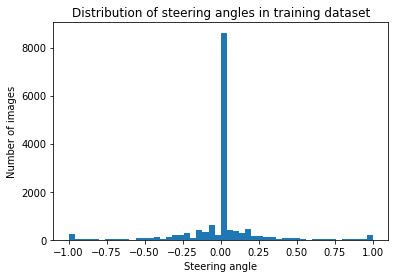

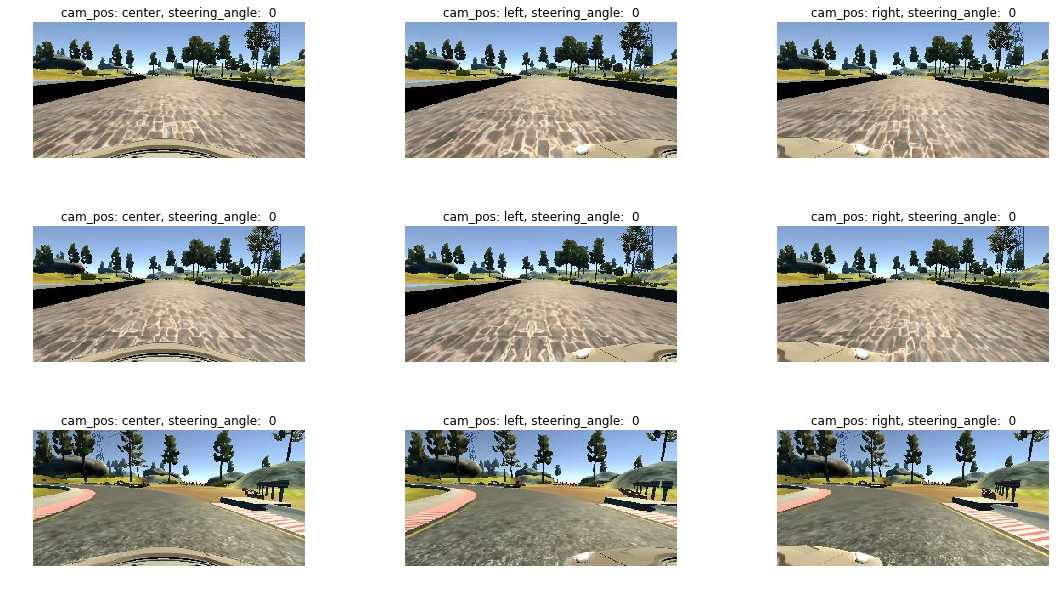

In [48]:
def load_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


def plot_images(images, titles, rows=3, cols=3, figsize=(20,10), gray=False):
    images_to_show = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axes = axes.ravel()
    for i in range(images_to_show):
        image = images[i]
        axes[i].axis('off')
        axes[i].imshow(image)
        axes[i].set_title(titles[i])


def plot_steering_distribution(dataset, title):
    steering = [np.float32(x[3]) for x in dataset]
    print('Steering angle range: (', min(steering), ',', max(steering), ')')
    plt.figure()
    plt.hist(steering, bins=50)
    plt.xlabel('Steering angle')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

    
# Show Steering angle distribution
plot_steering_distribution(samples, 'Distribution of steering angles in training dataset')

# Print some sample dataset images
camera_positions = ['center', 'left', 'right']
rows = 3
sample_images = []
sample_images_titles = []
for r in range(rows):
    for cam_pos in range(len(camera_positions)):
        sample_images.append(load_image(os.path.join(DATA_FOLDER_PATH, samples[r][cam_pos].strip())))       
        sample_images_titles.append("cam_pos: {}, steering_angle: {}".format(camera_positions[cam_pos], samples[r][3]))
plot_images(sample_images, sample_images_titles, rows=rows, cols=len(camera_positions), figsize=(20,10))

### Data set preprocessing
For Image preprocessing I applied the follwing fucntions:
* Crop image - crops the image, on top it's 35% to remove sky, trees etc, and bottom by 10% to remove the car hood
* Resize image - All images are resized to 64x64 pixels

In [54]:

def crop(image, top_percent=0.35, bottom_percent=0.1):
    """
    Crops an image according to the given parameters
    Args:
     - image: 
        source image
     - top_percent:
        The percentage of the original image will be cropped from the top of the image
     - bottom_percent:
        The percentage of the original image will be cropped from the bottom of the image
     Return:
      - The cropped image
    """
    assert 0 <= top_percent < 0.5, 'top_percent should be between 0.0 and 0.5'
    assert 0 <= bottom_percent < 0.5, 'top_percent should be between 0.0 and 0.5'

    top = int(np.ceil(image.shape[0] * top_percent))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))

    return image[top:bottom, :]


def resize(image, new_dim=(64, 64)):
    """
    Resize a given image according the the new dimension
    Args:
    - image:
        Source image
    - new_dim:
        A tuple which represents the resize dimension
    Return:
        Resized image
    """
    return cv2.resize(image, new_dim)

### Visualize data preprocessing

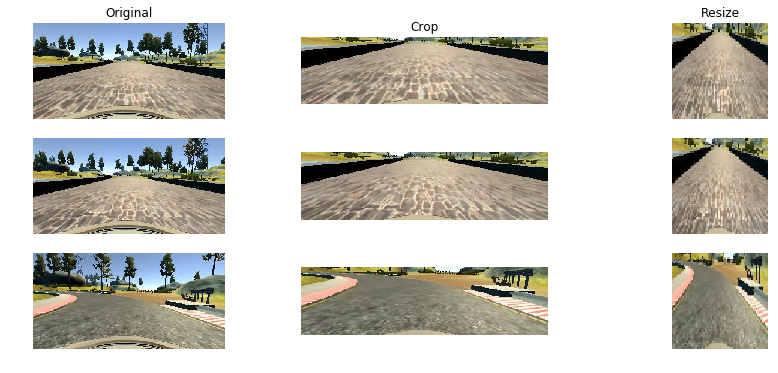

In [55]:
def display_preprocessed_data(images) :
    """
    Displays preprocessing pipeline for list of images
    """
    nrows = len(images)
    fig, axes = plt.subplots(nrows, 3, figsize=(15,2*nrows))
    
    # pre-processing pipeline
    preprocess_steps = ['Original','Crop','Resize']
    
    # plot pipeline
    for ax, p in zip(axes[0,:], preprocess_steps) :
        ax.set_title(p)
    for ax,img in zip(axes,images) :
        ax[0].imshow(img)
        img = crop(img)
        ax[1].imshow(img)
        img = resize(img)
        ax[2].imshow(img)
        for a in ax :
            a.axis('off')

rows = 3
preprocessed_images = []
for r in range(rows):
    preprocessed_images.append(load_image(os.path.join(DATA_FOLDER_PATH, samples[r][0].strip())))        
display_preprocessed_data(preprocessed_images)

### Data set augmentation

During training, you want to feed the left and right camera images to your model as if they were coming from the center camera. This way, you can teach your model how to steer if the car drifts off to the left or the right.

During prediction (i.e. "autonomous mode"), you only need to predict with the center camera image.
For Data augmentation I applied the follwing functions:
* Flip image - images are flipped by vertical axis and the sign of steering angle is changed
* Rotate image - Randomly rotated images

In [59]:
def flip_image(image, steering_angle):
    return np.fliplr(image), -1 * steering_angle


def random_rotation(image, steering_angle, rotation_amount=15):
    """
    params:
        - image:
        - steering_angle:
        - rotation_amount:
    return:
        - Randomly rotated image and steering_angle
    """
    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    rad = (np.pi / 180.0) * angle
    return scipy.ndimage.rotate(image, angle, reshape=False), steering_angle + (-1) * rad

In [62]:
def generate_new_image(img, steering_angle, top_crop_percent=0.35, bottom_crop_percent=0.1,
                       resize_dim=(64, 64)):
    img = crop(img, top_crop_percent, bottom_crop_percent)
    img, steering_angle = flip_image(img, steering_angle)
    img = resize(img, resize_dim)

    return img, steering_angle


def get_next_image_files(batch_size=64):
    """
    The simulator records three images (namely: left, center, and right) at a given time
    However, when we are picking images for training we randomly (with equal probability)
    one of these three images and its steering angle.
    Args:
    - batch_size:
        Size of the image batch
    Return:
        An list of selected (image files names, respective steering angles)
    """
    data = pd.read_csv(DRIVING_LOG_FILE)
    num_of_img = len(data)
    rnd_indices = np.random.randint(0, num_of_img, batch_size)

    image_files_and_angles = []
    for index in rnd_indices:
        rnd_image = np.random.randint(0, 3)
        if rnd_image == 0:
            img = data.iloc[index]['left'].strip()
            angle = data.iloc[index]['steering'] + STEERING_COEFFICIENT

        elif rnd_image == 1:
            img = data.iloc[index]['center'].strip()
            angle = data.iloc[index]['steering']
            image_files_and_angles.append((img, angle))
        else:
            img = data.iloc[index]['right'].strip()
            angle = data.iloc[index]['steering'] - STEERING_COEFFICIENT
            image_files_and_angles.append((img, angle))

    return image_files_and_angles

In [61]:
# Split data into training and validation datasets
shuffle(samples)
training_samples, validation_samples = train_test_split(samples, test_size=0.2) 
print("Number of training samples: {}".format(len(training_samples)))
print("Number of validation samples: {}".format(len(validation_samples)))

Number of training samples: 11740
Number of validation samples: 2935
